Notebook for plotting ripple features during natural sleep.

#### NRK TODO: update for eeg file with multiple electrodes

In [46]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots")
    # assert False, 'plot_dir not yet implemented on Nat laptop'
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    if environ["HOSTNAME"] == "lnx00035":
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy/'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.core.neurons import Neurons
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
if platform.system() == "Darwin": # Nat laptop
    dir_use = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/sessions/RatU/RatUDay2NSD")
    nchan_eeg = 1
    chan_use_rip = np.array([0])
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        dir_use = None
        assert "No data on Nat linux computer"
    if environ["HOSTNAME"] == "lnx00035":
        dir_use = Path("/data/Clustering/sessions/RatU/RatUDay2NSD/")
        nchan_eeg = 192
        chan_use_rip = np.arange(112, 127, 3)

In [10]:
from neuropy.core.session import ProcessData

eegfile = BinarysignalIO(sorted(dir_use.glob("*08-16-38.eeg"))[0], n_channels=nchan_eeg, sampling_rate=1250)
signal = eegfile.get_signal()

neurons = Neurons.load(sorted(dir_use.glob("*.neurons.stable.npy"))[0]).get_neuron_type("pyr")

ripple_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.ripple.npy"))[0])
ripple_epochs

rec_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.paradigm.npy"))[0])
rec_epochs

4 epochs
Snippet: 
    start   stop    label
0      0   9544      pre
1   9545  12855     maze
2  12856  45316     post
3  45317  48496  re-maze

In [18]:
from neuropy.analyses.oscillations import Ripple
id = 103
buffer = 0.25
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])

mean_swr_wvlt = Ripple.get_mean_wavelet(eegfile, chan_use_rip[0], rip_use)

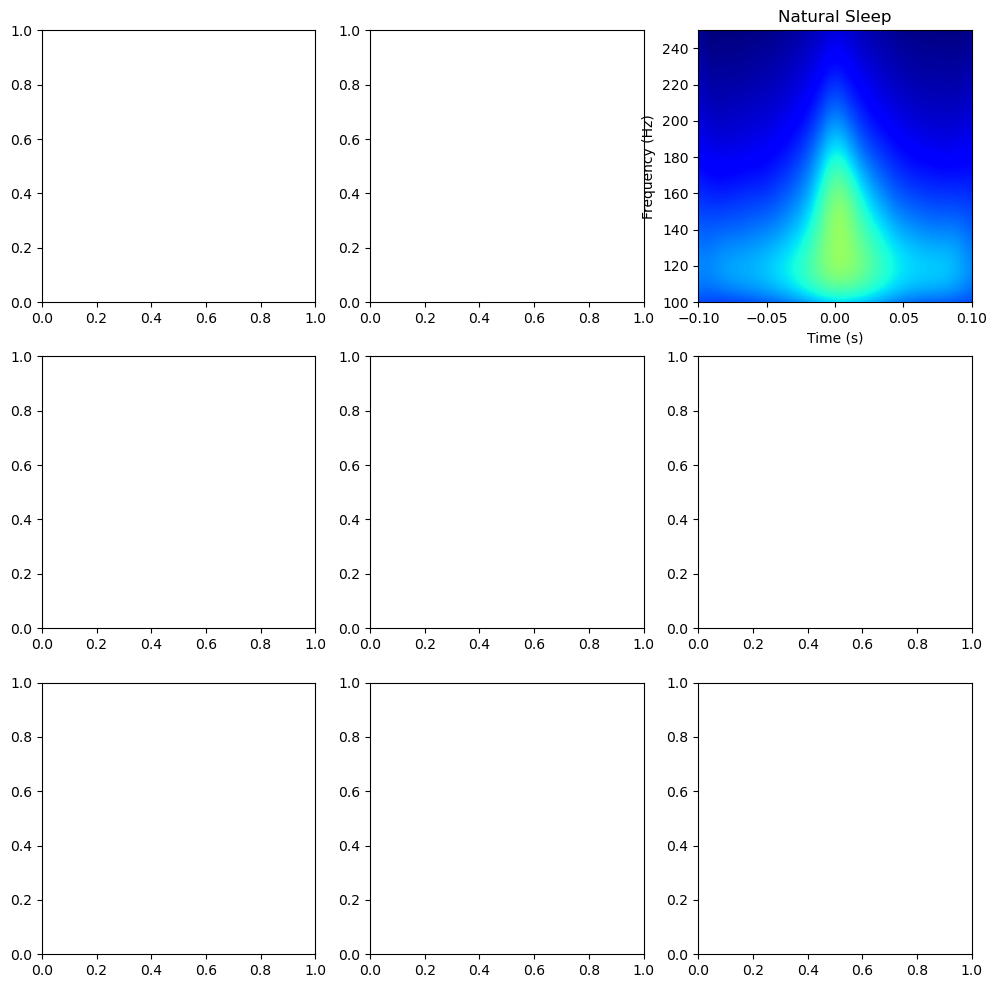

In [19]:
from neuropy.plotting.signals import plot_spectrogram
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[0][2])
ax[0][2].set_title("Natural Sleep")
# _, ax = plt.subplots()
# # sns.heatmap(mean_swr_wvlt.traces, cmap="jet", widget=False, freqax=ax)
fig.savefig(plot_dir / "NSD_wavelet_mean.pdf")

In [42]:
chan_use_rip

array([129, 132, 135, 138, 141])

In [31]:
216*60+18

12978

In [45]:
plot_dir

PosixPath('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD')

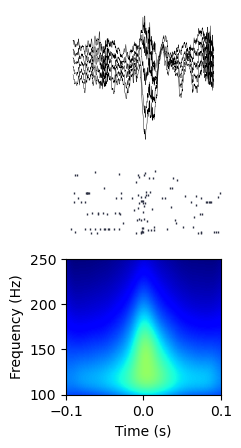

In [47]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster

fig, ax = plt.subplots(3, 1, figsize=(2, 5), height_ratios=[4, 2, 4])

id = 106
buffer = 0.25
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
plot_signal_traces(signal.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer,
                                     channel_id=chan_use_rip), ax=ax[0], lw=0.3)

plot_raster(neurons.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer), ax=ax[1])

plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[2])

for a in ax[0:2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")
    sns.despine(ax=a, left=True, bottom=True)

fig.savefig(plot_dir / "NSD_SWR_w_PBE.pdf")